In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [2]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
def bmi_convert(bmi):
    if bmi < 18.5:
        return 0
    if 18.5 <= bmi < 25:
        return 1
    if 25 <= bmi < 30:
        return 2
    if 30 <= bmi:
        return 3

In [4]:
def have_same_prefix(str1, str2):
    words_1 = str1.split("&")
    words_2 = str2.split("&")
    for i in range(len(words_1) - 1):
        if words_1[i] != words_2[i]:
            return False
    return True

def generate_new_name(str1, str2):
    words_1 = str1.split("&")
    words_2 = str2.split("&")
    new_str = ""
    for i in range(len(words_1)):
        new_str += words_1[i] + "&"
        if i == len(words_1) - 1:
            new_str += words_2[-1]
    return new_str

In [5]:
df = pd.read_csv("./diabetes_binary_health_indicators_BRFSS2015.csv")
df = df.astype(int)
df["BMI"] = df["BMI"].map(bmi_convert)
df["Male"] = df["Sex"]
df["Female"] = df["Sex"].map(lambda x: 1 - x)
df_new = df[["Diabetes_binary", "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "GenHlth", "DiffWalk", "Male", "Female", "Age"]]

cat_columns = ["BMI", "GenHlth", "Age"]
encoder = OneHotEncoder()
X = encoder.fit_transform(df_new[cat_columns]).toarray()
df_new.drop(cat_columns, axis=1, inplace=True)
new_columns = []
categories = encoder.categories_
for i in range(len(categories)):
    nc = list(categories[i])
    nc = [cat_columns[i] + "_" + str(val) for val in nc]
    new_columns += nc

X = X.astype(int)
one_hot = pd.DataFrame(X, columns=new_columns)
df_new = pd.concat([one_hot, df_new], axis=1)

/var/folders/fc/9w7nbmnj2y10_sl912glk3240000gn/T/ipykernel_16023/1557338452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(cat_columns, axis=1, inplace=True)


In [6]:
df_save = df_new.copy()

In [7]:
minconf = df_new["Diabetes_binary"].sum(axis=0) / len(df_new)
all_candidates = []
all_frequent_itemsets = []
candidates_k = list(df_new.columns)
candidates_k.remove("Diabetes_binary")
remove_list = []
for c in candidates_k:
    df_new[c] = df_new[c] & df_new["Diabetes_binary"]
    temp_conf = df_new[c].sum(axis=0) / df_save[c].sum(axis=0)
    if temp_conf < minconf:
        remove_list.append(c)
for c in remove_list:
    candidates_k.remove(c)

In [8]:
for _ in range(2):
    new_candidates = []
    for i in range(len(candidates_k)):
        for j in range(i + 1, len(candidates_k)):
            if have_same_prefix(candidates_k[i], candidates_k[j]):
                temp_vector = df_new[candidates_k[i]] & df_new[candidates_k[j]]
                temp_pop = df_save[candidates_k[i]] & df_save[candidates_k[j]]
                temp_conf = temp_vector.sum(axis=0) / temp_pop.sum(axis=0)
                if temp_conf >= minconf:
                    column_name = generate_new_name(candidates_k[i], candidates_k[j])
                    df_new[column_name] = temp_vector.copy()
                    df_save[column_name] = temp_pop.copy()
                    new_candidates.append(column_name)
    all_candidates.append(candidates_k)
    candidates_k = new_candidates


In [9]:
text = ""
for i in range(2):
    candidates = all_candidates[i]
    for c in candidates:
        vector = df_new[c]
        pop = df_save[c]
        conf = vector.sum(axis=0) / pop.sum(axis=0)
        text += f"{c} = {round(conf * 100, 2)}%\n"

In [10]:
file = open("./confidence.txt", 'w')
file.write(text)
file.close()

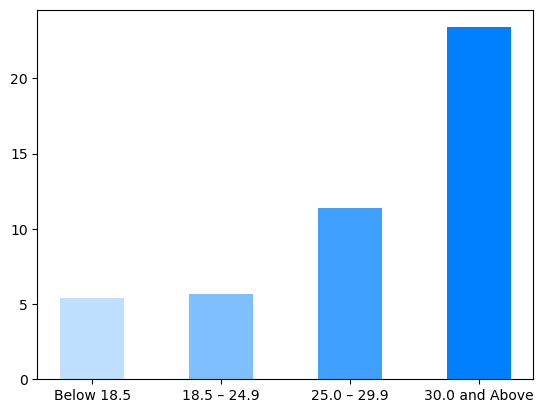

In [23]:
from matplotlib import cm

columns = ["BMI_0", "BMI_1", "BMI_2", "BMI_3"]
colors = [(0,0.5,1,0.25), (0,0.5,1,0.5), (0,0.5,1,0.75), (0,0.5,1,1)]
names = ["Below 18.5", "18.5 – 24.9", "25.0 – 29.9", "30.0 and Above"]
for i in range(len(columns)):
    vector = df_new[columns[i]]
    pop = df_save[columns[i]]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    plt.bar(names[i], round(conf*100, 2), color=colors[i], width=0.5)

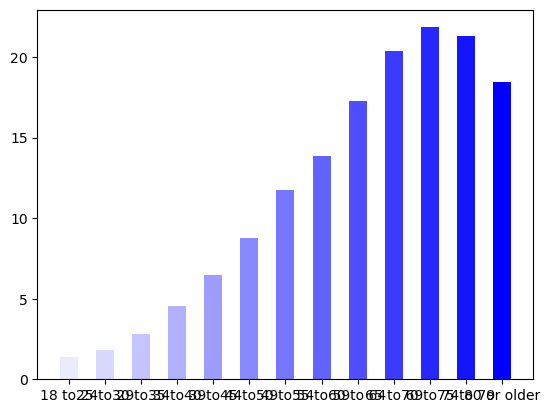

In [32]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()
for i in range(len(ages)):
    c = f"Age_{ages[i]}"
    vector = df_new[c]
    pop = df_save[c]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    plt.bar(names[i], round(conf*100, 2), color=(0,0,1,(i+1)/len(ages)), width=0.5)

In [11]:
df_new["Male"].sum() / df_save["Male"].sum()

0.1516033158469554

In [12]:
df_new["Female"].sum() / df_save["Female"].sum()

0.12967867355994758

In [13]:
df_new["Male"].sum() / df_save["Male"].sum() - df_new["Female"].sum() / df_save["Female"].sum()

0.02192464228700783